<a href="https://colab.research.google.com/github/zhouxuan01/zhouxuan01/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content.drive')

Mounted at /content.drive


In [76]:
! pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import  KFold

In [5]:
rating = pd.read_csv('/content.drive/MyDrive/ratings.csv')

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
rating = rating.drop(['timestamp'], axis = 1)


# **Question 1: Exploring the dataset**

**Q 1.1 Print the top 5 rows of the dataset**

In [8]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [25]:
rating.shape

(100004, 3)

**Q 1.2 Describe the distribution of ratings.**

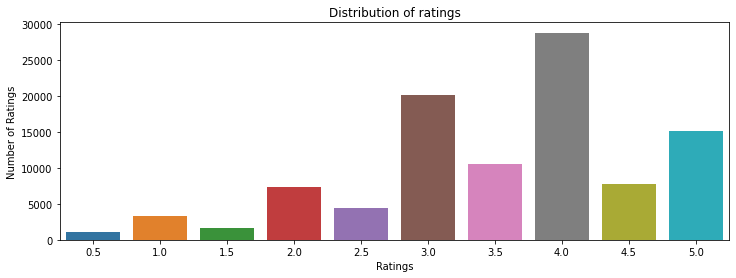

In [20]:
plt.figure(figsize = (12,4))
sns.countplot(rating['rating'])
plt.tick_params(labelsize = 10)
plt.title('Distribution of ratings')
plt.xlabel('Ratings', fontsize = 10)
plt.ylabel('Number of Ratings', fontsize = 10)
plt.show()

**Write your Answer here**: From this plot, we can tell, Rating '4' has the highest count (close to 30000), followed by rating '3' (around 20000 counts) and rating '5' with about 15000 counts
The ratings are little biased towards 3 and above more thn under 3

***Q 1.3 What is the total number of unique users and unique movies? ***

In [21]:
rating['userId'].nunique()

671

In [22]:
rating['movieId'].nunique()

9066

**Write your answer here**: 

The total number of unique users is '671'.  
The total number of unique movies is '9066'

**Q 1.4 Is there any movie that has been interacted with more than once by the same user?**

In [23]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [24]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**Write your Answer here:** Since the sum after groupby is equal to the total number of dataset in shape[0], all the interaction should be once between a pair of items and a user

**Q 1.5 Which is the most interacted movie in the dataset?**

In [33]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

**Write your Answer here:** MovieId 356 got most interactions from users

Text(0.5, 1.0, 'Distributions of ratings for movieId 356')

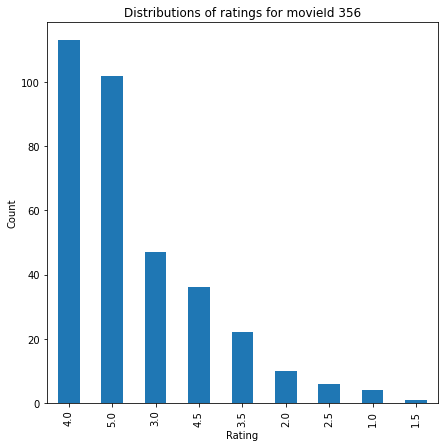

In [42]:
# Plotting distributions of ratings for 341 interactions with movieId 356 
plt.figure(figsize = (7,7))
rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distributions of ratings for movieId 356')

**Write your Answer here:** for movieId 356, out of these 341 interactions, more than 100 gave rating 4, following by a little of 100 users gave rating 5. Only very few people gave low ratings like 1, 1.5 

This tells us majority people like this movie

**Q 1.6 Which user interacted the most with any movie in the dataset?**

In [44]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Write your Answer here:** UserId 547 interacted the most with movies, showing 2391 interactions with movies.

**Q 1.7 What is the distribution of the user-movie interactions in this dataset?**

In [53]:
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

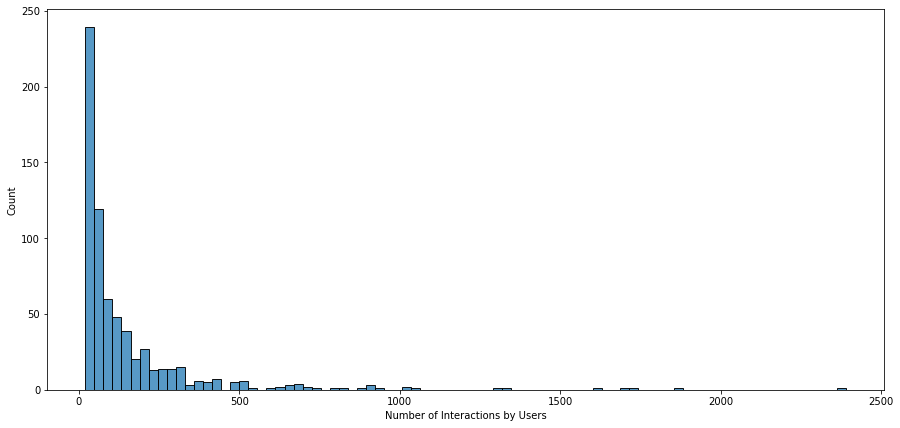

In [54]:
# Plotting user-movie interactions distribution
plt.figure(figsize = (15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

**Write your Answer here:** This distribution is right skewed with majority users have less than 500 interactions with movies.

# **Question 2: Create Rank-Based Recommendation System**

**Model 1: Rank-Based Recommendation System**

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [65]:
# Calculating average ratings:
average_rating = rating.groupby('movieId').mean()['rating']
# Calculating the count of ratings:
count_rating = rating.groupby('movieId').count()['rating']
# Making a dataframe with the count and average of ratings
final_rating = pd. DataFrame({'avg_rating' : average_rating, 'rating_count' : count_rating})

In [66]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation.

In [67]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

**Recommending top 5 movies with 50 minimum interactions based on popularity**

In [69]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 913, 1221, 50]

These **top 5 **movies (movieID: 858,318,913,1221 and 50) are recommended by using the popularity recommendation system

**Recommending top 5 movies with 100 minimum interactions based on popularity**

In [73]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

**Recommending top 5 movies with 200 minimum interactions based on popularity**

In [74]:
list(top_n_movies(final_rating, 5, 200))

[318, 50, 527, 608, 296]

# **Model 2: User based Collaborative Filtering Recommendation System**

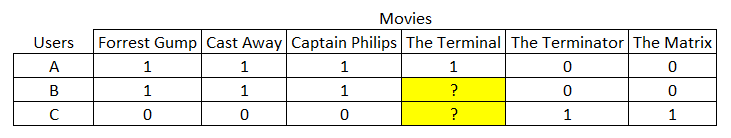collaborative_filtering.PNG

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -

1. **Ratings** provided by users. For example - ratings of books on goodread, movie ratings on imdb etc
2. **Likes** of users on different facebook posts, likes on youtube videos
3. **Use/buying** of a product by users. For example - buying different items on e-commerce sites
4. **Reading** of articles by readers on various blogs

**Types of Collaborative Filtering**

Similarity/Neighborhood based

    User-User Similarity Based
  
    Item-Item similarity based

Model based

**Building Similarity/Neighborhood based Collaborative Filtering**

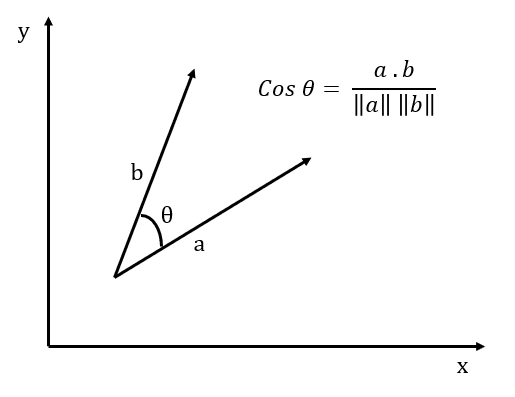

**Building a baseline user-user similarity based recommendation system**
  
  Below, we are building **similarity-based recommendation systems** using cosine similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.
  We will be using a new library, called **surprise**, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **rating dataset**, which is a **pandas DataFrame**, into a **different format called surprise.dataset.DatasetAutoFolds**, which is required by this library. To do this, we will be **using the classes Reader and Dataset**. Finally splitting the data into train and test set.

**Making the dataset into surprise dataset and splitting it into train and test set**

In [81]:
# Instantiating Reader scale with expected rating scale
reader = Reader (rating_scale = (0,5))

In [82]:
# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

In [85]:
# Splitting the data into train and test dataset
trainset,testset = train_test_split(data, test_size = 0.2, random_state = 42)

**Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [96]:
sim_options = {'name' :'cosine', 'user_based': True}
algo_knn_user = KNNBasic(sim_options = sim_options, verbose = False) 
# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Computer RMSE
accuracy.rmse(predictions)


RMSE: 0.9925


0.9924509041520163

**Q 3.1 What is the RMSE for baseline user based collaborative filtering recommendation system?**

Let's us now predict rating for an user with userId=4 and for movieId=10

In [97]:
algo_knn_user.predict(4,10,r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:** User 4, item 10 will get an estimate rating of 3.62 based on this similarity based baseline model

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3

In [98]:
algo_knn_user.predict(4,3,verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here**: Using the same model with the same user, but on the movie that this user have not ever rated (moveId 3), we estimated user 4 will give moveId 3 about 3.2 rating

**Improving user-user similarity based recommendation system by tuning its hyper-parameters**

**Q 3.3 Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system?**

In [100]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine'],'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9642729346867487
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


**Write your Answer here:** From this grid search, we can see the optimal hyperparameters for this KNNBasic model is: 'k' = 20, 'min_k' = 3, 'sim_options' = 'msd'}

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [101]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.966755,0.964353,0.961711,0.964273,0.002060,1,0.745390,0.740601,0.740315,0.742102,0.002328,1,0.141702,0.024931,2.948581,0.045438,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.996072,0.994007,0.990760,0.993613,0.002187,13,0.771672,0.767648,0.766804,0.768708,0.002124,12,0.681141,0.038033,3.292599,0.113267,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.970115,0.968877,0.967800,0.968931,0.000946,4,0.748594,0.742926,0.744786,0.745436,0.002359,3,0.177508,0.049150,3.394963,0.317978,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.997663,0.996811,0.995626,0.996700,0.000836,15,0.773505,0.768498,0.770547,0.770850,0.002055,15,0.625668,0.035964,4.015784,1.060198,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.976558,0.974827,0.972039,0.974475,0.001861,7,0.754078,0.747503,0.748718,0.750100,0.002856,6,0.218555,0.076167,3.473582,0.456762,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [103]:
# Using the optimal similarity measure for user_user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_options = {'name': 'msd', 'user_based': True}
similarity_algo_optimized_user = KNNBasic(sim_options = sim_options, k = 20, min_k = 3, verbose = False)

In [104]:
# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

In [105]:
# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

In [106]:
# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

**Write your Answer here:** This hyperparameters-tuned model, RMSE for testset has decreased from 0.99 to 0.95.  So this model is improving after tuning.

**Q 3.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering?**

Let's us now predict rating for an user with userId=4 and for movieId=10 with the optimized model

In [108]:
similarity_algo_optimized_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

**Write your Answer here:** Compared to the old model, this newer model is predicating better with estimated rating of 3.74.  It is closer to the real rating(4) comparing to the previous model, which is estimated at 3.62

Below we are predicting rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3, by using the optimized model as shown below 

In [109]:
similarity_algo_optimized_user.predict(4,3,verbose = True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

**Write your Answer here:** Comparing to previous model, which estimated for this moveId3 with rating of 3.2, now with the new calculation, we estimated user4 will give moveId3 rating of 3.72 instead of 3.2

**Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the userId=4 based on the msd distance metric

In [110]:
similarity_algo_optimized_user.get_neighbors(4, k = 5)

[665, 417, 647, 654, 260]

**Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are -

    data: a rating dataset

    user_id: an user id against which we want the recommendations

    top_n: the number of movies we want to recommend

    algo: the algorithm we want to use to predict the ratings



In [121]:
def get_recommendations(data, user_id, top_n, algo):
  # Creating an empty list to store the recommended movieIds
  recommendations = []
  # Creating an user item interaction matrix
  user_item_interactions_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')
  # Extracting those movieIds which the userId has not interacted yet
  non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
  # Looping through each of the movieId which userId has not interacted yet
  for item_id in non_interacted_movies:
    #Predicting the ratings for those non interacted movie ids by this user
    est = algo.predict(user_id, item_id).est
    # Appending the predicted ratings
    recommendations.append((item_id,est))
  # Sorting the predicted ratings in descending order
  recommendations.sort( key = lambda x: x[1], reverse = True)

  return recommendations[:top_n] # returning top_n highest predicted rating movies for this users

**Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [122]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

**Q 3.5 Predict the top 5 movies for userId=4 with similarity based recommendation system**

In [123]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

# **Model 3: Item based Collaborative Filtering Recommendation System**

In [128]:
# Definging similarity measure
sim_options = {'name': 'cosine', 'user_based' : False}
# Defining Nearest Neighbour algorithm
algo_knn_item = KNNBasic(sim_options = sim_options, verbose = False)
# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)
# Predict ratings for the testset
predictions = algo_knn_item.test(testset)
# Compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

**Q 4.1 What is the RMSE for baseline item based collaborative filtering recommendation system ?**

**Write your Answer here:** The RMSE for baseline item-based collaborative filtering recommendation system is about 1.00

**Q 4.2 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3?**

Let's us now predict rating for an user with userId=4 and for movieId=10

In [129]:
algo_knn_item.predict(4,10,r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:** The estimated rating for user4, movie10 is 4.37 based on this item-based collaborative system.  The actual rating is 4

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3

In [134]:
algo_knn_item.predict(4,3,verbose = True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:** Based on this model, we estimated user4 will give move3 a rating of 4.07

**Q 4.3 Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system?**

In [135]:
# Setting up parameter grid to tune the hyperparameters
param_grid = { 'k' : [20,30,40], 'min_k' : [3,6,9], 'sim_options' : {'name': ['msd', 'cosine'], 'user_based': [False]}}
# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# Fitting the data
grid_obj.fit(data)
# Best RMSE score
print(grid_obj.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9390045870612171
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


**Write your Answer here:** From this grid search, we can see the optimal hyperparameters for this KNNBasic model is: 'k' = 40, 'min_k' = 3, 'sim_options' = 'msd'}

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [136]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.946651,0.952133,0.948207,0.948997,0.002307,7,0.730698,0.736213,0.733119,0.733344,0.002257,7,7.284352,0.687484,11.406675,0.538544,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.012650,1.013946,1.010246,1.012281,0.001533,16,0.790395,0.791366,0.787914,0.789891,0.001454,16,19.481345,0.806031,10.950632,0.346910,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.947018,0.952010,0.948721,0.949250,0.002072,8,0.730902,0.736355,0.733563,0.733606,0.002226,8,6.473850,0.163695,11.448643,0.610013,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.013092,1.013804,1.010812,1.012569,0.001276,17,0.790674,0.791395,0.788379,0.790150,0.001286,17,19.294353,0.771163,11.508410,0.501479,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.947289,0.952080,0.949283,0.949551,0.001965,9,0.731008,0.736488,0.734238,0.733911,0.002249,9,6.280159,0.182830,11.964004,0.110030,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using t**uned values of the hyperparameters** which we received by using grid search cross-validation.

In [140]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic (sim_options = { 'name': 'msd', 'user_based' : False}, k = 40, min_k = 3, verbose = False)
# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)
# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)
# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

**Write your Answer here:** After tuning the model, the new RMSE for testset has decreased from 1.00 to 0.94.  Therefore this tuned model is improving.

**Q 4.4 What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering?**

Let's us now predict rating for an user with userId=4 and for movieId=10 with the optimized model as shown below

In [141]:
similarity_algo_optimized_item.predict(4, 10,r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:** The new estimated rating for movieId 10 of user4 is improved from 4.37 to 4.26

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3, by using the optimized model:

In [142]:
similarity_algo_optimized_item.predict(4,3,verbose = True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here**: Consequently, this model estimate user4 will give movieId3 a rating of 3.87 instead of 4.07

**Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the userId=4 based on the msd distance metric

In [143]:
similarity_algo_optimized_item.get_neighbors(4, k = 5)

[77, 85, 115, 119, 127]

**Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [144]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

**Q 4.5 Predict the top 5 movies for userId=4 with similarity based recommendation system**

In [145]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

# **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features**: The features that are not present in the empirical data but can be inferred from the data. For example:

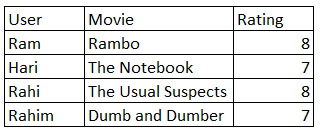

Now if we notice the above movies closely:

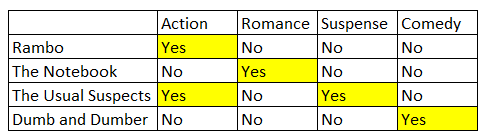

Here **Action, Romance, Suspense and Comedy **are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

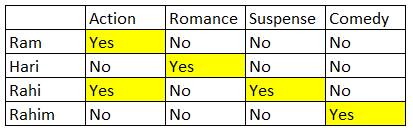

**Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

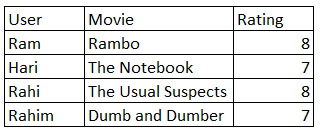

into an user-item matrix as shown below:

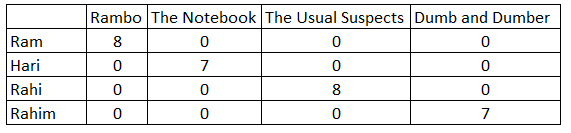

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices**:

  U matrix

  Sigma matrix

  V transpose matrix

**U-matrix**

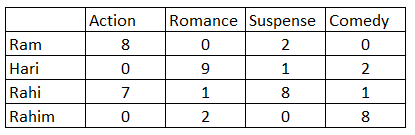

the above matrix is a n x k matrix, where:

n is number of users

k is number of latent features

**Sigma-matrix**

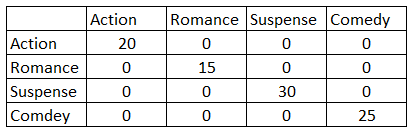

the above matrix is a k x k matrix, where:

  k is number of latent features

  Each diagonal entry is the singular value of the original interaction matrix

**V-transpose matrix**

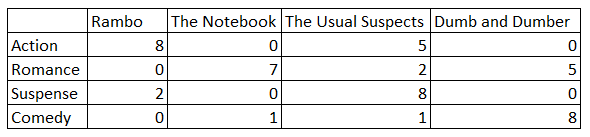

the above matrix is a kxn matrix, where:

  k is the number of latent features
  
  n is the number of items

**Build a baseline matrix factorization recommendation system**

In [146]:
# Using SVD matrix factorization
algo_svd = SVD()
# Training the algorithm on the trainset
algo_svd.fit(trainset)
# Predicting ratings for the testset
predictions = algo_svd.test(testset)
# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9012


0.9011651589289381

**Q 5.1 What is the RMSE for baseline SVD based collaborative filtering recommendation system?**

**Write your Answer here:** This SVD based collaborative filtering recommendation system generate RMSE of 0.90 which is better than tuned item-based, or user-based recommendation system.

**Q 5.2 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3?**

Let's us now predict rating for an user with userId=4 and for movieId=10

In [148]:
algo_svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.05   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.045870969814684, details={'was_impossible': False})

**Write your Answer here:** This rating of 4.05 is better than the previous two ratings: 4.26 and 4.37

Let's predict the rating for the same userId=4 but for a movie which this user has not interacted before i.e. movieId=3:

In [149]:
algo_svd.predict(4,3,verbose = True)

user: 4          item: 3          r_ui = None   est = 3.69   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6868812785152296, details={'was_impossible': False})

**Write your Answer here:** Based on this model, we estimated user4 will give movieId 3 a rating of 3.69

**Improving matrix factorization based recommendation system by tuning its hyper-parameters**

Below we will be tuning only three hyperparameters -

**n_epochs**: The number of iteration of the SGD algorithm

**lr_all:** The learning rate for all parameters

**reg_all**: The regularization term for all parameters